# Финальное задание

## Анализ структуры данных и предобработка

In [34]:
import matplotlib
matplotlib.use('Qt5Agg')  # Использование Qt5Agg вместо TkAgg
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [ ]:
 
# Загрузка данных в dataframe
data = pd.read_csv('./data/marketing_AB.csv')

data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [36]:
#  Удаление дубликатов
data = data.drop_duplicates(subset=['user id',])

# Удаление отсутвующих значений
data = data.dropna()

In [37]:
#  Замена значений поля 'converted' для дальнейших расчетов
replacement_dict = {False: 0, True: 1}
data['converted'] = data['converted'].map(replacement_dict )

In [38]:
# Замена для удобства
replacement_dict = {'ad': 'A', 'psa': 'B'}
data['test group'] = data['test group'].map(replacement_dict )

## Первичный анализ результатов A/B-тестирования


### Рассчет вспомогательных показателей для контрольной и тестовой групп

In [39]:
data_aux = data.groupby('test group').agg({
    'total ads': 'sum',
    'converted': 'sum'
}).reset_index().rename(columns={'converted': 'total converted'})

data_aux


,test group,total ads,total converted
0,A,14014701,14423
1,B,582481,420


Выводы: 
На основании сравнения показателей тестовой и контрольной групп можно сделать вывод что выборки групп не равнозначны и не сбалансированы.

### Расчет вспомогательных показателей

In [40]:

# Расчет количества посетителей сайта, суммарное совершение покупок, суммарное количество просмотров рекламы.
daily_data = data.groupby(['most ads day', 'most ads hour', 'test group']).agg({
    'user id': 'count',
    'converted': 'sum',
    'total ads': 'sum'
}).reset_index().rename(columns={'user id': 'users count'})


# Среднее количество простмотров
daily_data['mean ads'] = daily_data['total ads'] / daily_data['users count']

# Вычисление конверсии - связь покупок с просмотрами рекламы.
daily_data['conversion'] = daily_data['converted'] / daily_data['users count'] * 100


# кумулятивная конверсия
daily_data['cum_conversion'] = daily_data.groupby(['test group'])['conversion'].cumsum()
# кумулятивное число пользователей
daily_data['cum_users_count'] = daily_data.groupby(['test group'])['users count'].cumsum()
# кумулятивное число  покупок
daily_data['cum_converted'] = daily_data.groupby(['test group'])['converted'].cumsum()
# кумулятивное число средних просмотров рекламы
daily_data['cum_mean_ads'] = daily_data.groupby(['test group'])['mean ads'].cumsum()


daily_data

,most ads day,most ads hour,test group,users count,converted,total ads,mean ads,conversion,cum_conversion,cum_users_count,cum_converted,cum_mean_ads
0,Friday,0,A,807,16,21636,26.810409,1.982652,1.982652,807,16,26.810409
1,Friday,0,B,34,0,899,26.441176,0.000000,0.000000,34,0,26.441176
2,Friday,1,A,662,7,18753,28.327795,1.057402,3.040054,1469,23,55.138203
3,Friday,1,B,29,0,858,29.586207,0.000000,0.000000,63,0,56.027383
4,Friday,2,A,825,10,21495,26.054545,1.212121,4.252175,2294,33,81.192749
...,...,...,...,...,...,...,...,...,...,...,...,...
330,Wednesday,21,B,153,2,3955,25.849673,1.307190,219.988600,23276,417,4349.219733
331,Wednesday,22,A,3277,83,67803,20.690571,2.532804,381.604982,561693,14359,4448.631134
332,Wednesday,22,B,157,3,3101,19.751592,1.910828,221.899428,23433,420,4368.971325
333,Wednesday,23,A,2884,64,51423,17.830444,2.219140,383.824122,564577,14423,4466.461578


C:\Users\Santerr80\AppData\Local\Temp\ipykernel_26360\2526152868.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily_data, x='conversion', y='test group', orient='h', palette='Set2')


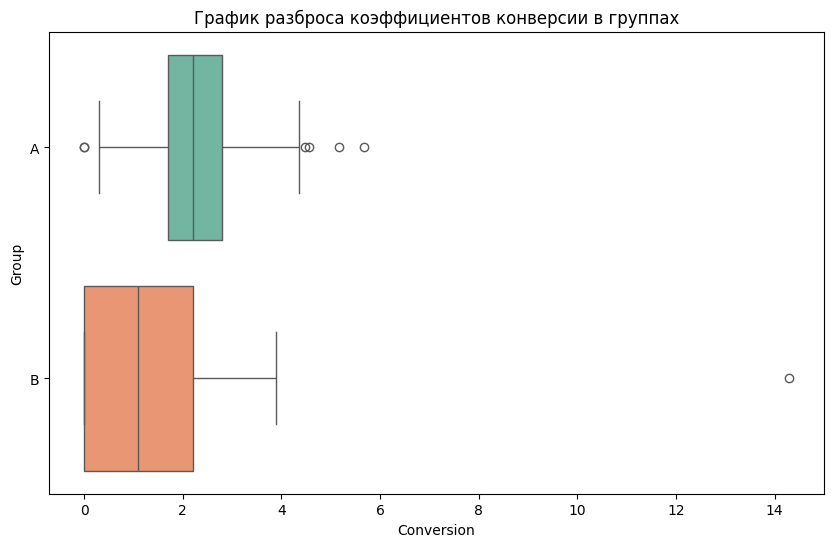

In [41]:
%matplotlib inline

# График данных распределения конверсии по группам 
plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_data, x='conversion', y='test group', orient='h', palette='Set2')

# Настройка графика
plt.xlabel('Conversion')
plt.ylabel('Group')
plt.title('График разброса коэффициентов конверсии в группах')

# Построить
plt.show()

Text(0.5, 1.0, 'График конверсии по дням недели в группах')

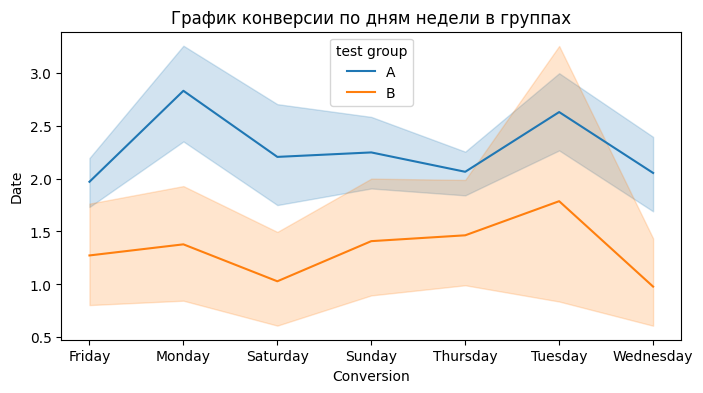

In [42]:
# График конверсии по дням недели
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=daily_data,
    x='most ads day',
    y='conversion',
    hue='test group')

# Adding labels and title
plt.xlabel('Conversion')
plt.ylabel('Date')
plt.title('График конверсии по дням недели в группах')


Промежуточные выводы:
На первый взгляд, на основании показателя конверсии, нулевая гипотеза (увеличесние показов рекламы увеличивает продажи) подтверждается.

## Cтатистический анализ результатов A/B-тестирования

Нулевая статистическая гипотеза - увеличение просмотра рекламы увеличивает конверсию

### Проведение статистических тестов для конверсии

In [43]:
from statsmodels.stats.proportion import proportions_ztest

converted_piv = daily_data.groupby('test group').agg(
    sum=('total ads', 'sum'),
    count=('converted', 'sum'))
display(converted_piv)

,sum,count
test group,,
A,14014701,14423
B,582481,420


In [44]:

alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['count'], #число «успехов»
    nobs=converted_piv['sum'], #общее число наблюдений
    alternative='two-sided')

# выводим результат на экран
print('p-value: ', round(p_value, 3))

# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")



p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


In [45]:
from statsmodels.stats.proportion import proportions_chisquare

alpha = 0.05 # уровень значимости
# вычисляем значение p-value для Z-теста для пропорций
_, p_value, c = proportions_chisquare(
    count=converted_piv['count'], #число «успехов»
    nobs=converted_piv['sum'] #общее число наблюдений
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")


p-value:  0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Промежуточный вывод:
Согласно z-тесту  и chi^2 r для конверсии есть статистическая разница. Нулевая гипотеза может быть отвергнута.

### Статистические тесты для средних значений просмотров в группах.

Тесты для среднего значения просмотра рекламы в группах

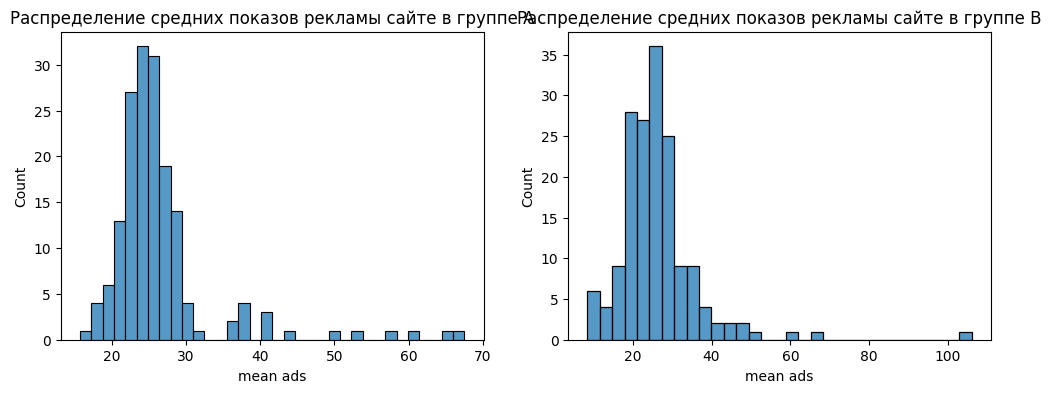

In [46]:
data_a = daily_data[daily_data['test group'] == 'A']
data_b = daily_data[daily_data['test group'] == 'B']


# создаём два графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='mean ads', data=data_a, ax=axes[0])
sns.histplot(x='mean ads', data=data_b, ax=axes[1])
# задаём названия графикам
axes[0].set_title('Распределение средних показов рекламы сайте в группе А')
axes[1].set_title('Распределение средних показов рекламы сайте в группе B')
plt.show()

In [47]:
# Проверка нормальности распределения total ads по методу Шапиро.

from scipy.stats import shapiro

alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(data_a['mean ads'])
shapiro_result_b = shapiro(data_b['mean ads'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы А с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе А является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе B является нормальным")


p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе А отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе B отлично от нормального


Так как распределение отличается от нормального, то для оценки средних  просмотров применяем тест Манна — Уитни 

In [48]:
from scipy.stats import mannwhitneyu

In [49]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=data_a['mean ads'],
    y=data_b['mean ads'],
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.62
У нас нет оснований отвергнуть нулевую гипотезу


Согласно тесту Манна — Уитни нулевая гипотеза подтверждается и распределения статистически равны. Распределения для средних значений просмотров рекламы в группах статистически равны. 

### Построение 95% доверительных интервалов.

In [50]:
from scipy.stats import norm

def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound


In [56]:
# строим доверительный интервал для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=data_a['converted'].sum()/data_a['users count'].sum(), # выборочная пропорция
    n=data_a['users count'].sum() # размер выборки
)

# строим доверительный интервал для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=data_b['converted'].sum()/data_b['users count'].sum(), # выборочная пропорция
    n=data_b['users count'].sum() # размер выборки
)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (np.float64(2.51), np.float64(2.6))
Доверительный интервал для конверсии в группе B: (np.float64(1.62), np.float64(1.95))


In [58]:

# размеры выборок групп А и B
n = [data_a['users count'].sum(), data_b['users count'].sum()]

# выборочная пропорция групп A и B
x_p = [data_a['converted'].sum()/data_a['users count'].sum(), data_b['converted'].sum()/data_b['users count'].sum()]

# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат

print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (np.float64(-0.94), np.float64(-0.6))


## Выводы

1. Согласно тесту Манна — Уитни распределения для средних значений просмотров рекламы в группах статистически равны.  
2. Построенные доверительные интервалы не пересекаются, что однозначно подтверждает верность нулеваой гипотезы с точностью в 95%.
3. Построенный доверительный интервал разницы пропорций (конверсий) показал, что истинная разница конверсий отрицательна вариант B хуже по метрике конверсии, чем вариант А с заданной надёжностью.

На основании проведенного A/B теста нулевая гипотеза подтверждается. 
